# Titanic: Machine Learning from Disaster

### Import Libraries

In [37]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Load Data

In [38]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [39]:
# Separate data and target values
y = train_df['Survived']
train_df = train_df.drop('Survived', axis=1)


### Visualize data before cleanup

In [40]:
train_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Analysis and Cleanup

* https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68
* https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python

In [41]:
# Shape of dataset, including generated columns
train_df.shape

(891, 11)

In [42]:
# What are our columns, again?
train_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [43]:
# General information about the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [44]:
train_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [45]:
train_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing Values

* https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [46]:
train_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Cabin

Unfortunately, over 77% of Cabin info is missing in the dataset. Discarding data which does not have cabin data is out of the question. Also, survival may have been affected by which cabin a person was in and consequently which deck they were on, when the Titanic sank. While we could set it to a new value like `U`, a better way would be to analyse the deck structure of RMS Titanic and assign cabins by class.

A cursory read-through of how Titanic's cabins were organized in Wikipedia gives the following insights:
* A-Deck: It was reserved exclusively for First Class passengers
* B-Deck: More First Class passenger accommodations were located here 
* C-Deck: Crew Cabins
* D-Deck: First, Second and Third Class passengers had cabins on this deck
* E-Deck: The majority of E-Deck was occupied by Second-Class
* F-Deck: Second and Third Class passengers

So, let us assign decks based on a passenger's class in the following way:
* First Class: Random assignment beteween A and B Decks
* Second Class: Random assignment between D and E Decks
* Third Class: Random assignment between E, F and G Decks

While we are at it, let's also convert values in Cabin column to Decks, because that's a better feature for our analysis.

In [47]:
# Convert Cabins to Decks
def convert_to_deck(cabin):
    if not pd.isna(cabin):
        cabin = cabin[0]
    return cabin

train_df['Deck'] = train_df['Cabin'].apply(convert_to_deck)

In [48]:
# Random assignment of Decks for passengers with no Cabin info
for i, row in train_df[train_df['Cabin'].isnull()].iterrows(): 
    if row['Pclass'] == 1:
        train_df.at[i, 'Deck'] = random.choice(['A', 'B'])
    elif row['Pclass'] == 2:
        train_df.at[i, 'Deck'] = random.choice(['D', 'E'])
    else:
        train_df.at[i, 'Deck'] = random.choice(['E', 'F', 'G'])

In [49]:
# Drop cabin from the dataset
train_df = train_df.drop('Cabin', axis=1)

#### Embarked

Most passengers boarded Titanic at Southampton (923, vs. 274 in Cherbourg and 123 in Queenstown). Let's just assign the missing `Embarked` values to `S` for Southampton.

In [50]:
# Update null values in Embarked to S

train_df['Embarked'].fillna('S', inplace=True)

In [51]:
# Also replace Embarked with numeric values
train_df.loc[train_df['Embarked'] == 'S', 'Embarked'] = 0
train_df.loc[train_df['Embarked'] == 'C', 'Embarked'] = 1
train_df.loc[train_df['Embarked'] == 'Q', 'Embarked'] = 2

print(train_df['Embarked'].unique())
print(train_df['Embarked'].value_counts())

[0 1 2]
0    646
1    168
2     77
Name: Embarked, dtype: int64


#### Age

The age of passengers is a very important attribute for our analysis, as Children were among the group of people onboard with a higher chance of survival (others being Women and Upper class). Removing records with no age information (~20% of the dataset) is not an option, neither is replacing the age with mean, median or mode. Let's use the age values we have from the other 80% of data to predict the missing 20%.

In [52]:
# Use Pandas Dataframe Interpolate to fill missing values!
train_df = train_df.interpolate()

In [53]:
# Or take the longer way to predict missing Age values
if train_df['Age'].isnull().sum() > 0:
    linear = LinearRegression()

    data_with_null = train_df[train_df['Age'].isnull()][['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']]
    data_without_null = train_df[['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']].dropna()

    age_train_X = data_without_null.drop('Age', axis=1)
    age_train_y = data_without_null['Age']

    # FIXME - Does the presence of PassengerId affect fit?
    linear.fit(age_train_X, age_train_y)

    age_predicted = data_with_null
    age_test_X = data_with_null.drop('Age', axis=1)

    age_predicted['Age'] = linear.predict(age_test_X)

    # https://stackoverflow.com/questions/41773728/pandas-fill-na-with-data-from-another-dataframe-based-on-same-id
    train_df_cleaned = train_df.set_index("PassengerId").combine_first(age_predicted.set_index("PassengerId")).reset_index()

    # Set Negative age to a particular value, say 5 years
    train_df_cleaned.loc[train_df['Age'] < 0., 'Age'] = 5

### Outliers

* https://statinfer.com/104-3-5-box-plots-and-outlier-dectection-using-python/

#### Fare

{'whiskers': [<matplotlib.lines.Line2D at 0x107de0a90>,
 'caps': [<matplotlib.lines.Line2D at 0x107dea390>,
 'boxes': [<matplotlib.lines.Line2D at 0x107de0940>],
 'medians': [<matplotlib.lines.Line2D at 0x107deabe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x107df3048>],
 'means': []}

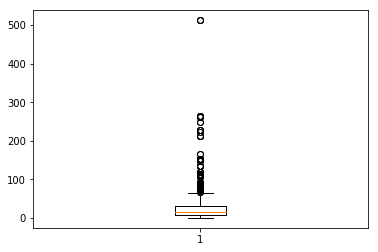

In [54]:
plt.boxplot(train_df['Fare'])

In [ ]:
# Remove outliers in Fare values


#### Age

{'whiskers': [<matplotlib.lines.Line2D at 0x107e37c88>,
 'caps': [<matplotlib.lines.Line2D at 0x107e40588>,
 'boxes': [<matplotlib.lines.Line2D at 0x107e37b38>],
 'medians': [<matplotlib.lines.Line2D at 0x107e40dd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x107e48240>],
 'means': []}

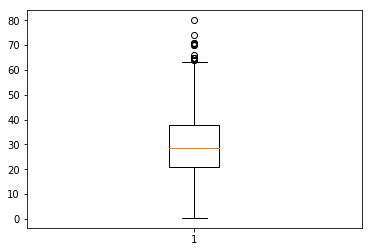

In [55]:
plt.boxplot(train_df['Age'])

## Feature Selection

### PCA

## Models and Predictions

## Conclusion